<a href="https://colab.research.google.com/github/cod3astro/kaggle_ML_competition/blob/main/loan_payback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
train = pd.read_csv('train.csv', index_col='id')
test = pd.read_csv('test.csv', index_col='id')
train.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
id,,,,,,,,,,,,
0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [45]:
train.shape

(593994, 12)

In [46]:
train.isnull().any().any()

np.False_

In [47]:
train.describe(include='all')

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
count,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994,593994,593994,593994,593994,593994,593994.000000
unique,NaN,NaN,NaN,NaN,NaN,3,4,5,5,8,30,NaN
top,NaN,NaN,NaN,NaN,NaN,Female,Single,Bachelor's,Employed,Debt consolidation,C3,NaN
freq,NaN,NaN,NaN,NaN,NaN,306175,288843,279606,450645,324695,58695,NaN
mean,48212.202976,0.120696,680.916009,15020.297629,12.356345,NaN,NaN,NaN,NaN,NaN,NaN,0.798820
std,26711.942078,0.068573,55.424956,6926.530568,2.008959,NaN,NaN,NaN,NaN,NaN,NaN,0.400883
min,6002.430000,0.011000,395.000000,500.090000,3.200000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,27934.400000,0.072000,646.000000,10279.620000,10.990000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
50%,46557.680000,0.096000,682.000000,15000.220000,12.370000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,60981.320000,0.156000,719.000000,18858.580000,13.680000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


In [48]:
def create_derived_features(df):
    df = train.copy()
    print(f"Processing dataset shape: {df.shape}")

    # 1. Rounding Features
    # This reduces noise by grouping similar values
    for col in ['annual_income', 'loan_amount']:
        if col in df.columns:
            # Round to nearest whole number (1s)
            df[f'{col}_ROUND_1s'] = df[col].round(0).astype(int)
            # Round to nearest ten (10s)
            df[f'{col}_ROUND_10s'] = df[col].round(-1).astype(int)
            print(f"  -> Created rounding features for {col}")

    # 2. Subgrade and Grade Extraction
    # Splits "B2" into Grade "B" and Subgrade "2"
    if 'grade_subgrade' in df.columns:
        df['grade'] = df['grade_subgrade'].str[0]
        # taking the rest of the string and converting to int
        df['subgrade'] = df['grade_subgrade'].str[1:].astype(int)
        print(f"  -> Extracted grade and subgrade")

    # 3. Total Debt Burden Calculation
    # Formula: (Loan Amount * Interest Rate) / Annual Income
    req_cols = ['loan_amount', 'interest_rate', 'annual_income']
    if all(col in df.columns for col in req_cols):
        df['total_debt_burden'] = (
            (df['loan_amount'] * df['interest_rate'] / 100) /
            (df['annual_income'] + 1) # +1 prevents division by zero error
        )
        print(f"  -> Calculated total_debt_burden")

    return df

# --- EXECUTION ---
print("STEP 1: Creating Derived Features...")

# Apply to Train Data
df = create_derived_features(train)

print("\nDone! Check your dataframe head to see new columns.")

STEP 1: Creating Derived Features...
Processing dataset shape: (593994, 12)
  -> Created rounding features for annual_income
  -> Created rounding features for loan_amount
  -> Extracted grade and subgrade
  -> Calculated total_debt_burden

Done! Check your dataframe head to see new columns.


In [50]:
def create_derived_features(test_df):
    test_df = test.copy()
    print(f"Processing dataset shape: {test_df.shape}")

    # 1. Rounding Features
    # This reduces noise by grouping similar values
    for col in ['annual_income', 'loan_amount']:
        if col in test_df.columns:
            # Round to nearest whole number (1s)
            test_df[f'{col}_ROUND_1s'] = test_df[col].round(0).astype(int)
            # Round to nearest ten (10s)
            test_df[f'{col}_ROUND_10s'] = test_df[col].round(-1).astype(int)
            print(f"  -> Created rounding features for {col}")

    # 2. Subgrade and Grade Extraction
    # Splits "B2" into Grade "B" and Subgrade "2"
    if 'grade_subgrade' in test_df.columns:
        test_df['grade'] = test_df['grade_subgrade'].str[0]
        # taking the rest of the string and converting to int
        test_df['subgrade'] = test_df['grade_subgrade'].str[1:].astype(int)
        print(f"  -> Extracted grade and subgrade")

    # 3. Total Debt Burden Calculation
    # Formula: (Loan Amount * Interest Rate) / Annual Income
    req_cols = ['loan_amount', 'interest_rate', 'annual_income']
    if all(col in test_df.columns for col in req_cols):
        test_df['total_debt_burden'] = (
            (test_df['loan_amount'] * test_df['interest_rate'] / 100) /
            (test_df['annual_income'] + 1) # +1 prevents division by zero error
        )
        print(f"  -> Calculated total_debt_burden")

    return test_df

# --- EXECUTION ---
print("STEP 1: Creating Derived Features...")
test_df = create_derived_features(test)

print("\nDone! Check your dataframe head to see new columns.")

STEP 1: Creating Derived Features...
Processing dataset shape: (254569, 11)
  -> Created rounding features for annual_income
  -> Created rounding features for loan_amount
  -> Extracted grade and subgrade
  -> Calculated total_debt_burden

Done! Check your dataframe head to see new columns.


In [51]:
df.shape

(593994, 19)

In [52]:
test_df.shape

(254569, 18)

In [53]:
feature_list = ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade', 'grade']
target_Column = train['loan_paid_back']

In [55]:
from sklearn.model_selection import KFold

def apply_target_encoding(df, test_df, feature_list, target_column, n_folds=10):

    # Applies Target Encoding with K-Fold Cross-Validation to prevent data leakage.
    # Work on copies to avoid messing up original dfs
    train_encoded = df.copy()
    test_encoded = test_df.copy()

    # Setup K-Fold
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    print(f"Starting Target Encoding on {len(feature_list)} features...")

    for feature in feature_list:
        # Create a new column name, e.g., 'mean_grade'
        new_col_name = f'mean_{feature}'

        # Initialize the new column with zeros
        train_encoded[new_col_name] = 0.0

        # --- PART A: ENCODE TRAINING DATA (With K-Fold) ---
        # We split train data into chunks. We calculate means on 9 chunks
        # and apply them to the 1 chunk we left out.
        for train_idx, val_idx in kfold.split(train_encoded):
            # Get the rows for this fold
            train_X_fold = train_encoded.iloc[train_idx]
            val_X_fold = train_encoded.iloc[val_idx]

            # Calculate mean target for each category in this fold
            target_means = train_X_fold.groupby(feature)[target_column].mean()

            # Map these means to the validation chunk
            train_encoded.loc[val_idx, new_col_name] = val_X_fold[feature].map(target_means)

        # Fill any NaNs in train (rare categories) with the global mean
        global_mean = df[target_column].mean()
        train_encoded[new_col_name] = train_encoded[new_col_name].fillna(global_mean)

        # --- PART B: ENCODE TEST DATA ---
        # For test data, we just use the mean from the ENTIRE training set
        # (This is allowed because test data is "future" data)
        global_target_means = df.groupby(feature)[target_column].mean()
        test_encoded[new_col_name] = test_encoded[feature].map(global_target_means)

        # Fill NaNs in test with global mean
        test_encoded[new_col_name] = test_encoded[new_col_name].fillna(global_mean)

        print(f"  -> Created {new_col_name}")

    return train_encoded, test_encoded

# --- EXECUTION ---

# 1. Define which columns to encode
# (Make sure these exist in your dataframe!)
cols_to_encode = ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade', 'grade']

# 2. Check if columns actually exist before running
valid_cols = [c for c in cols_to_encode if c in train_df.columns]

# 3. Run the function
train_df, test_df = apply_target_encoding(
    df,
    test_df,
    valid_cols,
    target_column='loan_paid_back'
)

print("\nTarget Encoding Complete.")

Starting Target Encoding on 7 features...
  -> Created mean_gender
  -> Created mean_marital_status
  -> Created mean_education_level
  -> Created mean_employment_status
  -> Created mean_loan_purpose
  -> Created mean_grade_subgrade
  -> Created mean_grade

Target Encoding Complete.


In [56]:
train_df.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,...,grade,subgrade,total_debt_burden,mean_gender,mean_marital_status,mean_education_level,mean_employment_status,mean_loan_purpose,mean_grade_subgrade,mean_grade
id,,,,,,,,,,,,,,,,,,,,,
0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,...,C,3,0.011769,0.801849,0.798620,0.809872,0.899373,0.802523,0.835599,0.847408
1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,...,D,3,0.026841,0.795701,0.799062,0.801979,0.894310,0.796776,0.696667,0.715627
2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,...,C,5,0.033484,0.795911,0.799196,0.809513,0.894361,0.797319,0.847187,0.847379
3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,...,F,1,0.016088,0.801921,0.799147,0.809975,0.894136,0.797424,0.624315,0.625832
4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,...,D,1,0.048790,0.795721,0.799128,0.809427,0.894031,0.802351,0.733585,0.715151


In [ ]:
numerical_col = df.select_dtypes(include=np.number).columns
numerical_col = numerical_col.drop('loan_paid_back')
skewness = df[numerical_col].skew().sort_values(ascending=False)

print("Skewness of numerical features:\n")
print(skewness)

Skewness of numerical features:

annual_income           1.719509
debt_to_income_ratio    1.406680
loan_amount             0.207360
interest_rate           0.049945
credit_score           -0.166993
dtype: float64


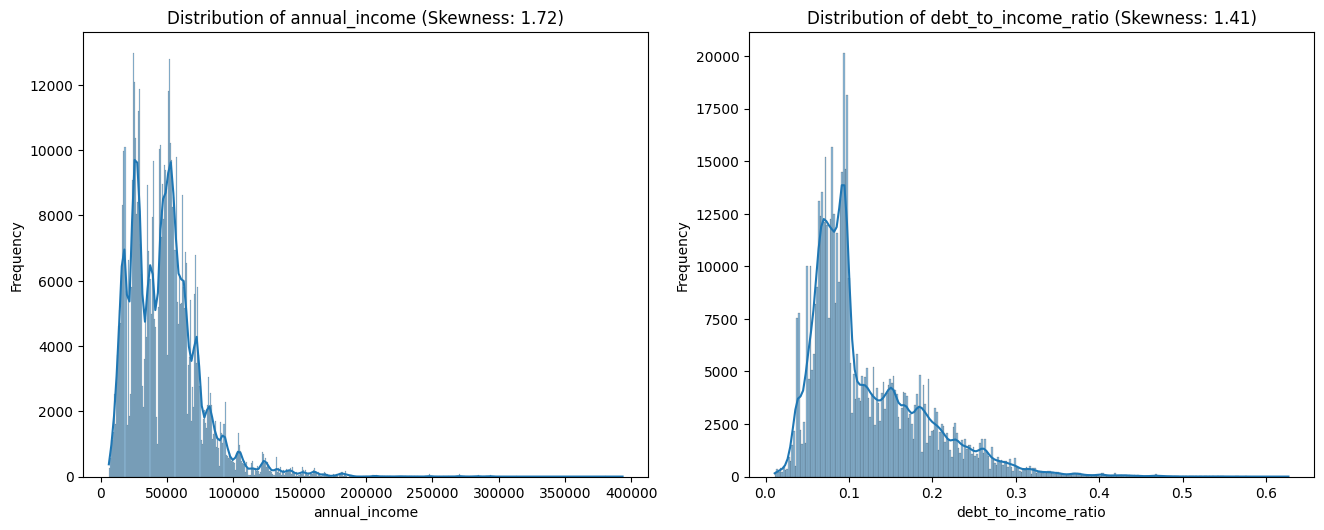

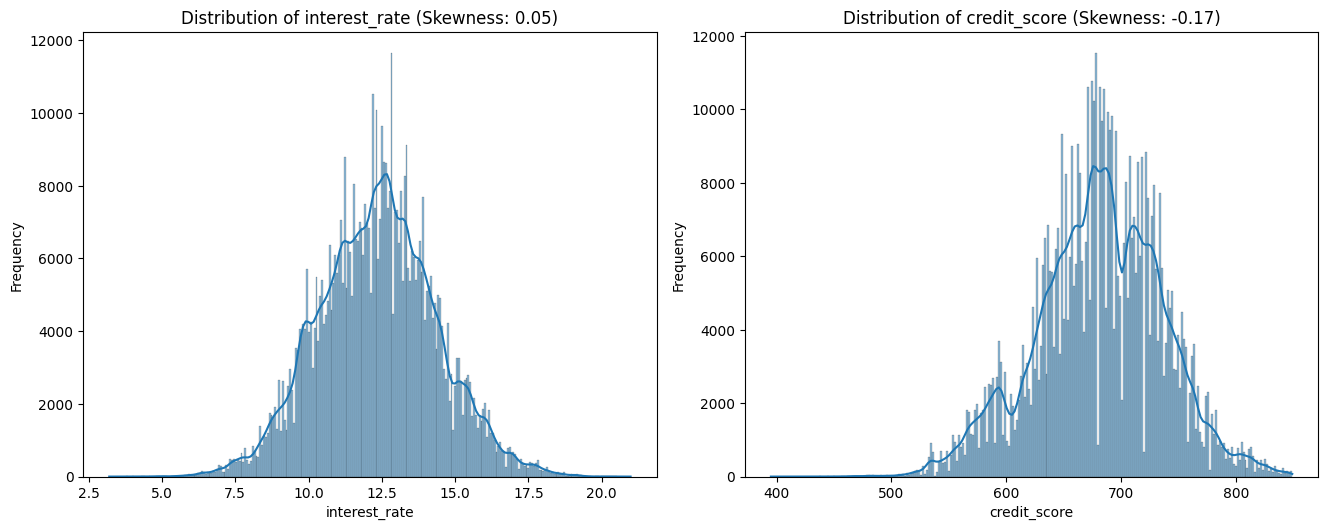

In [ ]:
top_skewed_features = skewness.head(2).index
bottom_skewed_features = skewness.tail(2).index

def plot_skewness(columns):
    plt.figure(figsize=(20, 10))
    for i, col in enumerate(columns):
        plt.subplot(2, 3, i + 1)
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col} (Skewness: {skewness[col]:.2f})')
        plt.xlabel(col)
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
plot_skewness(columns=top_skewed_features)
plot_skewness(columns=bottom_skewed_features)

In [ ]:
numerical_col

Index(['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount',
       'interest_rate'],
      dtype='object')

In [ ]:
from scipy.stats import boxcox

# Reload df to revert previous transformations on 'debt_to_income_ratio'
df = pd.read_csv('train.csv', index_col='id')

# Apply Box-Cox transformation to 'debt_to_income_ratio'
# Box-Cox requires data to be strictly positive. Check and ensure.
for col in ['debt_to_income_ratio', 'annual_income']:
    if (df[col] <= 0).any():
        print("Warning:", col, "contains non-positive values. Box-Cox might not be suitable or requires adjustment.")
    else:
        df[col], lambda_val = boxcox(df[col])
        print(f"Transformed skewness of debt_to_income_ratio (Box-Cox, lambda={lambda_val:.2f}): {df['debt_to_income_ratio'].skew():.2f}")


Transformed skewness of debt_to_income_ratio (Box-Cox, lambda=-0.05): 0.00
Transformed skewness of debt_to_income_ratio (Box-Cox, lambda=0.21): 0.00


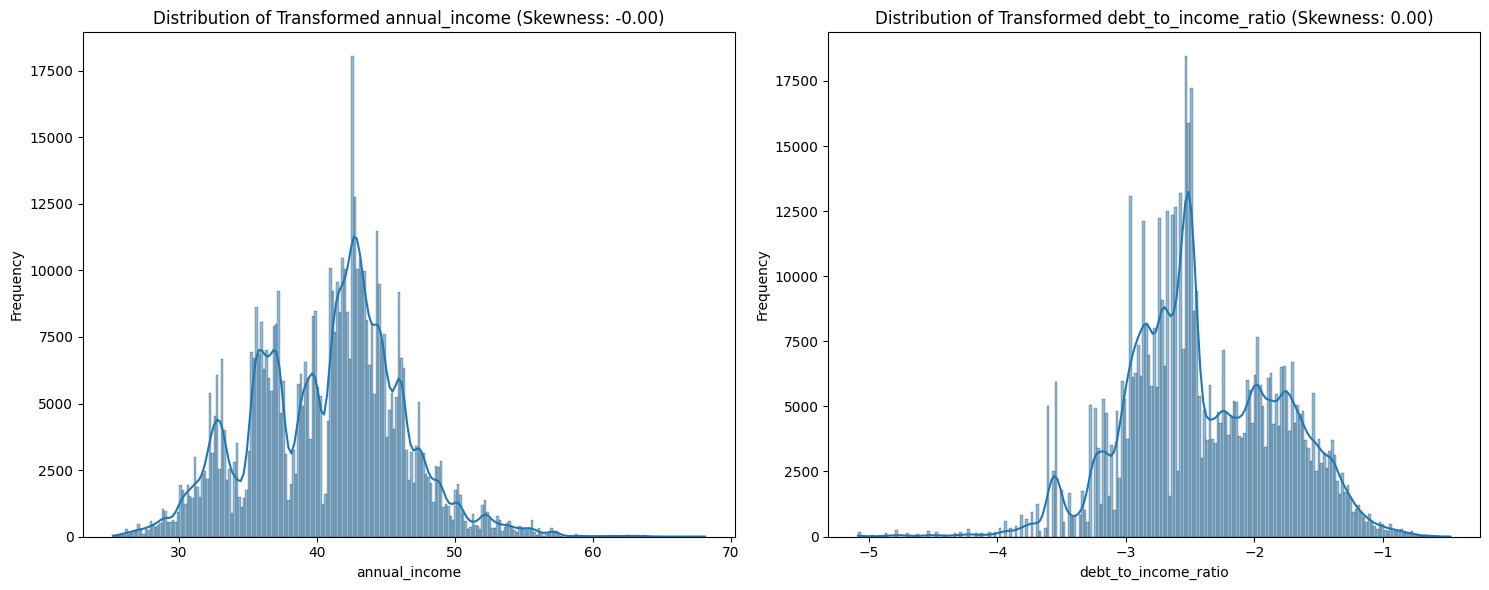

In [ ]:
transformed_features = ['annual_income', 'debt_to_income_ratio']

plt.figure(figsize=(15, 6))
for i, col in enumerate(transformed_features):
    plt.subplot(1, 2, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of Transformed {col} (Skewness: {df[col].skew():.2f})')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
categorical_col = df.select_dtypes(include='object').columns
for col in categorical_col:
    unique_values = df[col].unique()
    print(f'{col} ({len(unique_values)} unique)')
    print(df[col].unique())

gender (3 unique)
['Female' 'Male' 'Other']
marital_status (4 unique)
['Single' 'Married' 'Divorced' 'Widowed']
education_level (5 unique)
['High School' "Master's" "Bachelor's" 'PhD' 'Other']
employment_status (5 unique)
['Self-employed' 'Employed' 'Unemployed' 'Retired' 'Student']
loan_purpose (8 unique)
['Other' 'Debt consolidation' 'Home' 'Education' 'Vacation' 'Car'
 'Medical' 'Business']
grade_subgrade (30 unique)
['C3' 'D3' 'C5' 'F1' 'D1' 'D5' 'C2' 'C1' 'F5' 'D4' 'C4' 'D2' 'E5' 'B1'
 'B2' 'F4' 'A4' 'E1' 'F2' 'B4' 'E4' 'B3' 'E3' 'B5' 'E2' 'F3' 'A5' 'A3'
 'A1' 'A2']


In [ ]:
print(df.shape)

(593994, 12)


In [ ]:
df.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
id,,,,,,,,,,,,
0,37.240820,-2.644351,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,34.782138,-1.882706,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,42.180852,-2.481191,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,41.623855,-2.938172,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,35.998335,-3.174857,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [ ]:
df['loan_paid_back'].value_counts(normalize=True)

,proportion
loan_paid_back,
1.0,0.79882
0.0,0.20118


In [ ]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, roc_auc_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, NearMiss
from scipy.stats import pointbiserialr, chi2_contingency
from imblearn.pipeline import Pipeline as ImbPipeline

In [ ]:
X = df.drop(columns=['loan_paid_back', 'marital_status'])
y_unflipped = df['loan_paid_back']
y = y_unflipped.map({1: 0, 0: 1})

In [ ]:
X.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,education_level,employment_status,loan_purpose,grade_subgrade
id,,,,,,,,,,
0,37.240820,-2.644351,736,2528.42,13.67,Female,High School,Self-employed,Other,C3
1,34.782138,-1.882706,636,4593.10,12.92,Male,Master's,Employed,Debt consolidation,D3
2,42.180852,-2.481191,694,17005.15,9.76,Male,High School,Employed,Debt consolidation,C5
3,41.623855,-2.938172,533,4682.48,16.10,Female,High School,Employed,Debt consolidation,F1
4,35.998335,-3.174857,665,12184.43,10.21,Male,High School,Employed,Other,D1


In [ ]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cramers_scores = {}
for col in categorical_col:
    cramers_scores[col] = cramers_v(df[col], df['loan_paid_back'])

X_num = df[numerical_col]
y = df['loan_paid_back']
mi_scores = mutual_info_classif(X_num, y, discrete_features=False)
mi_scores_dict = dict(zip(numerical_col, mi_scores))

all_scores = {**cramers_scores, **mi_scores_dict}
all_scores_series = pd.Series(all_scores).sort_values(ascending=False)

print("\n📊 Combined Feature Correlation Report with Target:")
print(all_scores_series)


📊 Combined Feature Correlation Report with Target:
employment_status       0.656820
grade_subgrade          0.227867
debt_to_income_ratio    0.080032
credit_score            0.034137
loan_purpose            0.025437
education_level         0.025274
loan_amount             0.012772
interest_rate           0.012072
annual_income           0.011097
gender                  0.007202
marital_status          0.001375
dtype: float64


In [ ]:
onehot_col = ['gender', 'employment_status', 'loan_purpose']
ordinal_col = ['education_level']

In [ ]:
education_level = ['High School', "Bachelor's", "Master's", 'PhD', 'Other']
subgrade_order = {
    'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5,
    'B1': 6, 'B2': 7, 'B3': 8, 'B4': 9, 'B5': 10,
    'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 'C5': 15,
    'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20,
    'E1': 21, 'E2': 22, 'E3': 23, 'E4': 24, 'E5': 25,
    'F1': 26, 'F2': 27, 'F3': 28, 'F4': 29, 'F5': 30
}

X['grade_subgrade'] = X['grade_subgrade'].map(subgrade_order)
X['grade_subgrade'] = X['grade_subgrade'].fillna(31)
numerical_col = numerical_col.tolist() # Convert Index to list
numerical_col.append('grade_subgrade')

# Preprocessing steps
numerical_transformer = StandardScaler()
onehot_transformer = OneHotEncoder(handle_unknown='ignore')
ordinal_transformer = OrdinalEncoder(categories=[education_level], handle_unknown='use_encoded_value', unknown_value=-1)

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_col),
        ('onehot', onehot_transformer, onehot_col),
        ('ordinal', ordinal_transformer, ordinal_col)
    ],
    remainder='passthrough' # Keep other columns (like 'is_train' if present, though it's dropped from X)
)

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=42, stratify=y)

In [ ]:
train_X.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,education_level,employment_status,loan_purpose,grade_subgrade
id,,,,,,,,,,
83160,46.261988,-1.610654,695,8520.98,17.02,Male,Bachelor's,Unemployed,Home,12
58330,33.273382,-0.845985,619,15458.58,12.23,Male,Bachelor's,Self-employed,Debt consolidation,17
189451,39.443924,-1.951060,683,10579.22,9.35,Female,Bachelor's,Employed,Debt consolidation,14
135863,37.055311,-2.119239,634,20880.06,12.77,Male,High School,Employed,Debt consolidation,16
334421,47.535331,-2.232890,668,12093.96,12.18,Female,High School,Employed,Other,16


In [ ]:
negatives = (train_y == 1).sum()
positives = (train_y == 0).sum()
scale_weight = negatives / positives

print(f"Negatives: {negatives}, Positives: {positives}")
print(f"Calculated scale_pos_weight: {scale_weight:.2f}")

Negatives: 89625, Positives: 355870
Calculated scale_pos_weight: 0.25


In [ ]:
brf_model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', BalancedRandomForestClassifier(n_estimators=200,  sampling_strategy='all', replacement=True, random_state=42))
    ])
brf_model.fit(train_X, train_y)
brf_preds = brf_model.predict(val_X)

print("Accuracy:", accuracy_score(val_y, brf_preds))
print('ROC AUC SCORE: ', roc_auc_score(val_y, brf_preds))
print(confusion_matrix(val_y, brf_preds))

Accuracy: 0.879561478528475
ROC AUC SCORE:  0.8278493465658661
[[ 22147   7728]
 [ 10157 108467]]


In [ ]:
xgb_model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(random_state=42, scale_pos_weight=scale_weight, max_depth=14, n_estimators=200, learning_rate=0.04))
    ])
xgb_model.fit(train_X, train_y)

# Get hard predictions for accuracy and confusion matrix
xgb_hard_preds = xgb_model.predict(val_X)

# Get probabilities for ROC AUC score (for the positive class, which is 1.0 in val_y)
xgb_probs = xgb_model.predict_proba(val_X)[:, 1]

print("Accuracy:", accuracy_score(val_y, xgb_hard_preds))
print('ROC AUC SCORE: ', roc_auc_score(val_y, xgb_probs))
print(confusion_matrix(val_y, xgb_hard_preds))

Accuracy: 0.8988343355847515
ROC AUC SCORE:  0.917164458030888
[[ 15757  14118]
 [   905 117719]]


In [ ]:
lgbm_model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LGBMClassifier(random_state=42, subsample=1, num_leaves=31, n_estimators=200, learning_rate=0.1, colsample_bytree=0.7, ))
    ])

lgbm_model.fit(train_X, train_y)

# Get hard predictions for accuracy and confusion matrix
lgbm_hard_preds = lgbm_model.predict(val_X)

# Get probabilities for ROC AUC score (for the positive class, which is 1.0 in val_y)
lgbm_probs = lgbm_model.predict_proba(val_X)[:, 1]

print("Accuracy:", accuracy_score(val_y, lgbm_hard_preds))
print('ROC AUC SCORE: ', roc_auc_score(val_y, lgbm_probs))
print(confusion_matrix(val_y, lgbm_hard_preds))

[LightGBM] [Info] Number of positive: 355870, number of negative: 89625
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1342
[LightGBM] [Info] Number of data points in the train set: 445495, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798819 -> initscore=1.378931
[LightGBM] [Info] Start training from score 1.378931


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.9043495242392204
ROC AUC SCORE:  0.9213584285299892
[[ 17990  11885]
 [  2319 116305]]


In [ ]:
test = pd.read_csv('test.csv', index_col='id')
# Drop 'marital_status' from the test set to ensure consistency with the training data (X)
test = test.drop(columns=['marital_status'])

# Update the onehot_col list globally to reflect the dropped 'marital_status'
onehot_col = ['gender', 'employment_status', 'loan_purpose']
ordinal_col = ['education_level']
numerical_col = test.select_dtypes(include=np.number).columns
test.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,education_level,employment_status,loan_purpose,grade_subgrade
id,,,,,,,,,,
593994,28781.05,0.049,626,11461.42,14.73,Female,High School,Employed,Other,D5
593995,46626.39,0.093,732,15492.25,12.85,Female,Master's,Employed,Other,C1
593996,54954.89,0.367,611,3796.41,13.29,Male,Bachelor's,Employed,Debt consolidation,D1
593997,25644.63,0.110,671,6574.30,9.57,Female,Bachelor's,Employed,Debt consolidation,C3
593998,25169.64,0.081,688,17696.89,12.80,Female,PhD,Employed,Business,C1


In [ ]:
from scipy.stats import boxcox

education_level = ['High School', "Bachelor's", "Master's", 'PhD', 'Other']
subgrade_order = {
    'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5,
    'B1': 6, 'B2': 7, 'B3': 8, 'B4': 9, 'B5': 10,
    'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 'C5': 15,
    'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20,
    'E1': 21, 'E2': 22, 'E3': 23, 'E4': 24, 'E5': 25,
    'F1': 26, 'F2': 27, 'F3': 28, 'F4': 29, 'F5': 30
}

# 1. Map 'grade_subgrade' to numerical values in the test set
test['grade_subgrade'] = test['grade_subgrade'].map(subgrade_order)
test['grade_subgrade'] = test['grade_subgrade'].fillna(31) # Handle any unknown subgrades
test['grade_subgrade'] = test['grade_subgrade'].astype(int) # Explicitly cast to integer

# 2. Apply Box-Cox transformation to 'annual_income' and 'debt_to_income_ratio' in the test set
for col in ['debt_to_income_ratio', 'annual_income']:
    if (test[col] <= 0).any():
        print(f"Warning: {col} in test set contains non-positive values. Adjusting for Box-Cox.")
        test[col] = test[col] + 1e-6 # Add a small constant to make values positive
    test[col], _ = boxcox(test[col])

# 3. Redefine numerical_col AFTER all numerical transformations are applied to `test`
numerical_col = test.select_dtypes(include=np.number).columns.tolist()

In [ ]:
test_predictions = lgbm_model.predict_proba(test)

submission_df1 = pd.DataFrame({
    'id': test.index,
    'loan_paid_back': test_predictions[:, 1],
})

submission_df1.to_csv('my_submission4.csv', index=False)
print("Submission file saved successfully!")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Submission file saved successfully!


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
test_preds = []

# --- Define a single preprocessor for all data (train/val/test)
numerical_transformer = StandardScaler()
onehot_transformer = OneHotEncoder(handle_unknown='ignore')
ordinal_transformer = OrdinalEncoder(categories=[education_level], handle_unknown='use_encoded_value', unknown_value=-1)

preprocessor_single = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_col),
        ('onehot', onehot_transformer, onehot_col),
        ('ordinal', ordinal_transformer, ordinal_col)
    ],
    remainder='passthrough'
)

# Loop through 5 folds
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    # Apply preprocessing using the single preprocessor instance
    X_train_processed = preprocessor_single.fit_transform(X_train_fold)
    X_val_processed = preprocessor_single.transform(X_val_fold)

    # Calculate ratio for this specific fold
    ratio = float(np.sum(y_train_fold == 0)) / np.sum(y_train_fold == 1)

    model = lgb.LGBMClassifier(scale_pos_weight=ratio, n_estimators=1000, learning_rate=0.05, max_depth=5, reg_alpha=0.1, random_state=42)

    model.fit(
        X_train_processed, y_train_fold,
        eval_set=[(X_val_processed, y_val_fold)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(stopping_rounds=50)]
    )

    # Predict probabilities
    val_probs = model.predict_proba(X_val_processed)[:, 1]
    score = roc_auc_score(y_val_fold, val_probs)
    print(f"Fold {fold+1} AUC: {score:.4f}")
    auc_scores.append(score)

    # Transform the test set using the *same fitted preprocessor_single* from this fold
    test_processed = preprocessor_single.transform(test)
    test_fold_preds = model.predict_proba(test_processed)[:, 1]
    test_preds.append(test_fold_preds)

print(f"Average Local AUC: {np.mean(auc_scores):.4f}")

# Average the predictions from all folds
final_test_predictions = np.mean(test_preds, axis=0)

submission_df = pd.DataFrame({
    'id': test.index,
    'loan_paid_back': final_test_predictions,
})

submission_df.to_csv('lgbm_submission_cv.csv', index=False)
print("Cross-validated LightGBM submission file saved successfully!")

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[52]	valid_0's auc: 0.914337	valid_0's binary_logloss: 0.338007
Fold 1 AUC: 0.9143


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[52]	valid_0's auc: 0.913938	valid_0's binary_logloss: 0.33821
Fold 2 AUC: 0.9139


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	valid_0's auc: 0.912502	valid_0's binary_logloss: 0.339935


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 3 AUC: 0.9125


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's auc: 0.913518	valid_0's binary_logloss: 0.338771
Fold 4 AUC: 0.9135


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	valid_0's auc: 0.913401	valid_0's binary_logloss: 0.33824
Fold 5 AUC: 0.9134


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Average Local AUC: 0.9135
Cross-validated LightGBM submission file saved successfully!
